In [1]:
import numpy as np
import keras

import sys
import os

from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import Bidirectional, TimeDistributed, GRU
from keras.layers import LSTM, Input, Reshape, Concatenate, Flatten,Convolution1D
from keras.layers import Conv1D, Conv2D, GlobalMaxPooling1D, MaxPooling1D, MaxPool2D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam, SGD
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score

import itertools
import pandas as pd

import spacy
import nltk
import re

from tqdm import tqdm
from os.path import expanduser, exists

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
# pd.set_option('display.max_colwidth', 300) #widen pandas rows display

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Loading data...
['FAKE' 'REAL']
2 classes
Found 105976 unique tokens.
x_train shape: (5037, 100)
x_test shape: (1260, 100)
y_train shape: (5037, 2)
y_test shape: (1260, 2)
Found 105976 unique tokens.
Load data...


NameError: name 'sequence_length' is not defined

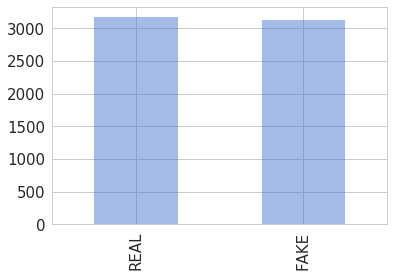

In [2]:
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('/home/paperspace/sonic/fakeNews/')

from data_util import get_fake_or_real_news, get_politifact, get_fact_fake

x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_fake_or_real_news()
# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_politifact()
# x_train, x_test, y_train, y_test, word_index, labels, num_classes, X, y = get_fact_fake()

vocabulary_inv = dict((v, k) for k, v in word_index.items())
print('Found %s unique tokens.' % len(vocabulary_inv))
vocabulary_inv[0] = "<PAD/>"
 
# Data Preparation
print("Load data...")
# x_train, y_train, x_test, y_test, vocabulary_inv = load_data(data_source)
# x_train, y_train, x_test, y_test, vocabulary_inv = load_data_hansard(data_train)

if sequence_length != x_test.shape[1]:
    print("Adjusting sequence length for actual size")
    sequence_length = x_test.shape[1]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

# x_train[:10]

In [ ]:
def plot_history(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def plot_confusion_matrix(model, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    y_pred = model.predict(x_test)
    # print(y_pred[:10])
    # print(y_test[:10])
    class_labels = np.argmax(y_test, axis=1) 
    # print(class_labels[:10])
    # print(y_pred.argmax(axis=1))
    print(metrics.classification_report(class_labels, y_pred.argmax(axis=1), 
                                        target_names=data_train['label'].unique(), digits=3))
    
    cm = confusion_matrix(class_labels, 
                          y_pred.argmax(axis=1))
    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

#     plt.figure(figsize=(12,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Emedding

In [ ]:
embeddings_index = {}
KERAS_DATASETS_DIR = expanduser('~/.keras/datasets/')
GLOVE_FILE = 'glove.840B.300d.txt'

print("Processing", GLOVE_FILE)

embeddings_index = {}
with open(KERAS_DATASETS_DIR + GLOVE_FILE, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding

print('Word embeddings: %d' % len(embeddings_index))

In [ ]:
def get_embedding_layer():
    count = 0
    embedding_matrix = np.random.uniform(-1,0,(len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            count += 1
            
    print('Word embeddings: %d' % len(embeddings_index))
    print('found number of tokens in embedding space: ', count)

    embedding_layer = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False)
    return embedding_layer


In [ ]:
# %%time


# from keras.layers import TimeDistributed
# from keras.layers import RepeatVector

# epochs=50
# batch_size=128
# # configure problem
# n_features = 50
# n_timesteps_in = 5
# n_timesteps_out = 2

# def encoder_decoder_baseline():
#     # define model
#     model = Sequential()
#     model.add(get_embedding_layer())
#     model.add(LSTM(150, dropout=0.2, recurrent_dropout=0.2))
# #     model.add(LSTM(150, input_shape=(n_timesteps_in, n_features)))
#     model.add(RepeatVector(n_timesteps_in))
#     model.add(LSTM(150, return_sequences=True))
#     model.add(TimeDistributed(Dense(MAX_SEQUENCE_LENGTH, activation='softmax')))
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
#     return model

# model = encoder_decoder_baseline()

# print(model.summary())

# network_hist = model.fit(x_train, y_train,
#                     batch_size=batch_size,
#                     validation_data=(x_test, y_test),
#                     epochs=epochs,
#                     verbose=1,
#                     validation_split=0.2)

# score = model.evaluate(x_test, y_test,
#                        batch_size=batch_size, verbose=1)

# print('Test loss:', score[0])
# print('Test accuracy:', score[1])
# print(score)

# plot_history(network_hist)

# # Plot normalized confusion matrix
# plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
%%time

# Very hopefull... work on this
# https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py
epochs=50
batch_size=128


# train a 1D convnet with global maxpooling
def word_embedding_model():
    print('building word embedding model')
    embedding_layer = get_embedding_layer()
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(64, 5, activation='relu')(embedded_sequences)
    x = MaxPooling1D(5)(x)
    x = Conv1D(64, 5, activation='relu')(x)
    x = MaxPooling1D(5)(x)
    x = Conv1D(64, 5, activation='relu')(x)
    x = GlobalMaxPooling1D()(x)
    x = Dense(64, activation='relu')(x)
    preds = Dense(num_classes, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    
    return model

model = word_embedding_model()

print(model.summary())


network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])
print(score)
print(model.metrics_names)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
# 84% 85%
# epochs = 20
# batch_size = 64

def imbd_lstm():
    print('Build LSTM model...')
    model = Sequential()
    model.add(get_embedding_layer())
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(num_classes, activation='sigmoid'))

    # try using different optimizers and different optimizer configs
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
    
    return model

model = imbd_lstm()

print(model.summary())

print('Train...')
network_hist = model.fit(x_train, y_train, 
                         batch_size=batch_size, epochs=epochs,
                         verbose=1, validation_data=(x_test, y_test),
                         validation_split=0.2)


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:

# https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-RNN/
# 81%
# epochs=10
batch_size=128

def getRNN_classifier():
    embedding_layer = get_embedding_layer()
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_lstm = Bidirectional(LSTM(128))(embedded_sequences)
    preds = Dense(num_classes, activation='softmax')(l_lstm)

    model = Model(sequence_input, preds)

    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    
    return model

model = getRNN_classifier()

    
print("model fitting - Bidirectional LSTM")
model.summary()

network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
%%time

# https://github.com/Theo-/sentiment-analysis-keras-conv/blob/master/train_keras.py

def sentiment_keras():
    model = Sequential()

    embedding_layer = get_embedding_layer()
    model.add(embedding_layer)

    # Convolutional model (3x conv, flatten, 2x dense)
    model.add(Convolution1D(64, 3, padding='same'))
    model.add(Convolution1D(32, 3, padding='same'))
    model.add(Convolution1D(16, 3, padding='same'))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(180, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='sigmoid'))


    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    
    return model

model = sentiment_keras()

print(model.summary())


network_hist = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    validation_data=(x_test, y_test),
                    epochs=epochs, verbose=1,
                    validation_split=0.2)

score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)

print('Test score:', score[0])
print('Test accuracy:', score[1])

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_cnn.py
# 81% 82%
# set parameters:
batch_size = 256
filters = 250
kernel_size = 3
hidden_dims = 250
# epochs = 10

def imbd_cnn():

    print('Build model...')
    model = Sequential()
    # we start off with an efficient embedding layer which maps
    # our vocab indices into embedding_dims dimensions
#     model.add(get_embedding_layer())
    model.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
    model.add(Dropout(0.2))

    # we add a Convolution1D, which will learn filters
    # word group filters of size filter_length:
    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))
    # we use max pooling:
    model.add(GlobalMaxPooling1D())

    # We add a vanilla hidden layer:
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    # try using different optimizers and different optimizer configs
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
    return model
    
model = imbd_cnn()

print(model.summary())

print('Training...')
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, validation_split=0.2,
          validation_data=(x_test, y_test))


score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)

print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
%%time

# https://github.com/keras-team/keras/blob/master/examples/imdb_cnn_lstm.py
# 85% - 82% -85% 86%
# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 128
# epochs = 20

def LSTMModel():
    print('Build model...')

    model = Sequential()
    model.add(get_embedding_layer())

    model.add(Dropout(0.2))

    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))

    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(LSTM(lstm_output_size))

    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))

    # try using different optimizers and different optimizer configs
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
    
    return model

model = LSTMModel()

print(model.summary())

print('Train...')
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, validation_split=0.2,
          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
%%time

# https://github.com/bhaveshoswal/CNN-text-classification-keras/blob/master/model.py
# 84% - %83 - 83%
vocabulary_size = len(word_index) 
# embedding_dim = 100
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5

# epochs = 20
# batch_size = 10

def CNNTextClassification():
    # this returns a tensor
    print("Creating Model...")
    inputs = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = get_embedding_layer()
    embedding = embedding_layer(inputs)
    # Embedding(input_dim=vocabulary_size, output_dim=embedding_dim, input_length=sequence_length)

    reshape = Reshape((MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, 1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBEDDING_DIM), 
                    padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBEDDING_DIM), 
                    padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBEDDING_DIM), 
                    padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[0] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[1] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(MAX_SEQUENCE_LENGTH - filter_sizes[2] + 1, 1), 
                          strides=(1,1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=num_classes, activation='softmax')(dropout)

    # this creates a model that includes
    model = Model(inputs=inputs, outputs=output)

    checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_acc:.4f}.hdf5', 
                                 monitor='val_acc', verbose=1, save_best_only=True, mode='auto')

    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(optimizer=adam, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = CNNTextClassification()
print(model.summary())

print("Traning Model...")
network_hist = model.fit(x_train, y_train, batch_size=batch_size, 
                         epochs=epochs, verbose=1, 
                         validation_data=(x_test, y_test))  # starts training

score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
# Keras convolutional model
# 80% 85% 85%

# batch_size = 10
epochs = 30

def keras_conv():
    model = Sequential()
    model.add(get_embedding_layer())
    model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
    model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
    model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
    model.add(Conv1D(32, kernel_size=3, activation='elu', padding='same'))
    model.add(Dropout(0.25))

    model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
    model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
    model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
    model.add(Conv1D(32, kernel_size=2, activation='elu', padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    # model.add(Dense(256, activation='tanh'))
    model.add(Dense(256, activation='sigmoid'))
    model.add(Dropout(0.5))


    model.add(Dense(units=num_classes, activation='softmax'))

    adam = Adam(lr=0.0001, decay=1e-6)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])
    return model

mdoel = keras_conv()

print(model.summary())

print('Training...')
# Fit the model
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          validation_data=(x_test, y_test),
          callbacks=[EarlyStopping(min_delta=0.00025, patience=2)])


score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)


# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
%%time

# simple 
# epochs = 20

# 84%, 82%, 83%

def simple_model():
    # define model
    print('simpel model')
    model = Sequential()
    model.add(get_embedding_layer())
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid'))

    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    # compile the model
    model.compile(optimizer=adam, 
                  loss='categorical_crossentropy', metrics=['acc'])
    return model

model = simple_model()

print(model.summary())

print('Training...')
# Fit the model
network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          validation_data=(x_test, y_test))


score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:

# https://richliao.github.io/supervised/classification/2016/12/26/textclassifier-RNN/
# 83% 83% 86%
epochs = 20

def RNN_model():
    embedding_layer = get_embedding_layer()
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    l_lstm = Bidirectional(LSTM(100))(embedded_sequences)

    preds = Dense(num_classes, activation='softmax')(l_lstm)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model


model = RNN_model()
print("model fitting - Bidirectional LSTM")
print(model.summary())

network_hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          validation_data=(x_test, y_test))

score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

plot_history(network_hist)

# Plot normalized confusion matrix
plot_confusion_matrix(model, classes=labels, title='Confusion matrix')

In [ ]:
def create_model():
    # create model
    embedding_layer = get_embedding_layer()
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    model = Sequential()
    model.add(embedding_layer)
    
    model.add(Dense(128, input_dim=MAX_SEQUENCE_LENGTH, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    
    model.add(Flatten())
    model.add(Dense(num_classes, activation='sigmoid'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
#     print(model.summary())
    return model

In [ ]:


kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

def GRUModel():
    print('Build model...')

    model = Sequential()
    model.add(get_embedding_layer())

    model.add(Dropout(0.2))

    model.add(Conv1D(filters,
                     kernel_size,
                     padding='valid',
                     activation='relu',
                     strides=1))

    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(GRU(lstm_output_size))

    model.add(Dense(num_classes))
    model.add(Activation('sigmoid'))

    # try using different optimizers and different optimizer configs
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss='categorical_crossentropy',
                  optimizer='RMSprop',
                  metrics=['accuracy'])
    
    return model

model = GRUModel()

print(model.summary())

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
import itertools
from tqdm import tqdm
from sklearn.metrics import confusion_matrix



def test(model, data):
    x_test, y_test = data
    y_pred = model.predict(x_test, batch_size=30)
    print('-' * 50)
#     print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1)) / y_test.shape[0])
#     print(y_pred)
    y_pred = model.predict_classes(x_test)
#     print(y_pred)
    
#     print(np.argmax(y_pred, 1))

#     print(classification_report(np.argmax(y_test, axis=1), 
#                                 y_pred, target_names=target_names))
    
#     result = model.evaluate(x_test, y_test, batch_size=batch_size)
#     print( confusion_matrix(y_test, y_pred, 1) )
    f1 = f1_score(np.argmax(y_test, 1), y_pred, average='macro')  
    percision = precision_score(np.argmax(y_test, 1), y_pred, average='macro')  
    recall = recall_score(np.argmax(y_test, 1), y_pred, average='macro')

    return f1, percision, recall

In [ ]:
%%time


epochs = 10
batch_size=64

print(X.shape)
print(Y.shape)

# evaluate using 10-fold cross validation
skf = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

models = {
#     'not_learning' : not_learning() ,
#     'create_model' : create_model(),
#     'getRNN_classifier' : getRNN_classifier(),
#     'simple_model' : simple_model(),
#     'ker/as_conv' : keras_conv(),
#     'RNN_model' : RNN_model(),
#     'CNNTextClassification' : CNNTextClassification(),
#     'LSTMModel' : LSTMModel(),
#     'word_embedding_model' : word_embedding_model(),
#     'sentiment_keras' : sentiment_keras(),
#     'imbd_lstm' : imbd_lstm(),
#     'GRUModel' : GRUModel(),
#     'imbd_cnn' : imbd_cnn()
}
# def getModel(name):
#     if(not_learning):
#         return not_learning()
#     else if('create_model' ):
#         return create_model()
#     else if('getRNN_classifier' ):
#         return getRNN_classifier()
#     else if('simple_model'):
#          return simple_model()
#     else if('keras_conv' ):
#         return keras_conv()
#     else if('RNN_model' ):
#          return RNN_model(),
#     else if('CNNTextClassification' ):
#     #     'CNNTextClassification' : CNNTextClassification(),
#     else if('LSTMModel'):
#         return LSTMModel()
#     else if('word_embedding_model' ):
#         return word_embedding_model(),
#     else if('sentiment_keras' ):
#         return sentiment_keras(),
#     else if('imbd_lstm' ):
#          return imbd_lstm(),
#     else if('GRUModel' ):
#         'GRUModel' : GRUModel(),
#         else if('create_model' ):
# #     'imbd_cnn' : imbd_cnn()

score = []


for train_index, test_index in tqdm(skf.split(X, y)):
#     print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = Y[train_index], Y[test_index]

    model =  GRUModel() 

    model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs, verbose=0,
          validation_data=(x_test, y_test))

#         result = model.evaluate(x_test, y_test, batch_size=batch_size)
    f1, percision, recall = test(model=model, data=(x_test, y_test))
    score.append({'f1': f1, 'percision' : percision, 'recall' : recall})
    print('F1: ', f1, ' percision: ', percision, ' recall: ', recall)
    
#     print(score_temp)
#     score.append([name, score_temp])
#     print('average percision over kfolds:', np.average([x['percision'] for x in score_temp]))

print('average f1 over kfolds:', np.average([x['f1'] for x in score]))
print('average percision over kfolds:', np.average([x['percision'] for x in score]))
print('average recall over kfolds:', np.average([x['recall'] for x in score]))

# print(score)
df_result = pd.DataFrame(score)
df_result.head()

df_result.to_csv('data/NNResults.csv')

In [ ]:

df_result.plot()
df_result

In [ ]:
print('average score over kfolds:', np.mean([x[1] for x in score]))
